# CPU or GPU 

In [1]:
import tensorflow as tf
# # Configuración de TensorFlow para usar la GPU
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

# Configuración de TensorFlow para usar la CPU
tf.config.set_visible_devices([], 'GPU')

# LIBRARIES 

In [44]:
# Library EEG
import mne

# Library System 
import os
import numpy as np
from tqdm import tqdm
import time

# Library Statistics
import scipy.stats
import random
from scipy.stats import entropy
from scipy.fft import fft
from scipy.signal import welch

# Library GAN
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Reshape, Conv2DTranspose, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Library Graph
import matplotlib.pyplot as plt
import seaborn as sns

# Library Visualitation
from mne.minimum_norm import make_inverse_operator, apply_inverse

# No Warning
import warnings
warnings.filterwarnings("ignore")
mne.set_log_level("ERROR")

In [3]:
os.getcwd()

'C:\\Users\\macka\\TFM_WD\\ORI\\SEEDs_FIF_RECOG_GAN'

# STATISTICS CALCULATES

# INTERPOLACIÓN

In [4]:
start_time = time.time()
# 1. Cargar y preparar los datos
emotion='POSITIVE' # 'NEGATIVE' 'NEUTRAL'
emotion_folder =f'C://Users//macka//TFM_WD//ORI//SEEDs_FIF_RECOG_GAN//{emotion}'
file_list = [file for file in os.listdir(emotion_folder) if file.endswith('.fif')]

eeg_data_list = []
for file in file_list:
    file_path = os.path.join(emotion_folder, file)
    eeg_data = mne.io.read_raw_fif(file_path, preload=False)
    eeg_data_list.append(eeg_data.get_data())

channel_names=eeg_data.ch_names
# Determine the common length for interpolation
common_length =50000  # You can adjust this value depending on your needs

interpolated_eeg_data_list = []

for eeg_data in tqdm(eeg_data_list,leave=False):
    num_channels = eeg_data.shape[0]
    original_length = eeg_data.shape[1]
    new_eeg_data = np.zeros((num_channels, common_length))

    for ch_idx in range(num_channels):
        x_original = np.linspace(0, 1, original_length)
        x_new = np.linspace(0, 1, common_length)
        new_eeg_data[ch_idx] = np.interp(x_new, x_original, eeg_data[ch_idx])

    interpolated_eeg_data_list.append(new_eeg_data)

eeg_data_tensor = np.stack(interpolated_eeg_data_list, axis=0).astype(np.float32)
eeg_data_tensor = (eeg_data_tensor - np.min(eeg_data_tensor)) / (np.max(eeg_data_tensor) - np.min(eeg_data_tensor)) * 2 - 1

In [14]:
eeg_data_tensor.shape

(612, 62, 50000)

In [15]:
num_muestras = eeg_data_tensor.shape[0]
num_canales = eeg_data_tensor.shape[1]
num_puntos_por_canal = eeg_data_tensor.shape[2]

# 2. Crear el modelo GAN
# Generador
def build_generator(latent_dim):
    input_layer = Input(shape=(latent_dim,))

    x = Dense(32)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(64)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(num_canales * num_puntos_por_canal, activation='tanh')(x)
    output_layer = Reshape((num_canales, num_puntos_por_canal))(x)

    return Model(input_layer, output_layer)

# Discriminador
def build_discriminator():
    input_layer = Input(shape=(num_canales, num_puntos_por_canal))
    x = Flatten()(input_layer)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.5)(x)

    x = Dense(64)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.5)(x)

    x = Dense(32)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.5)(x)

    output_layer = Dense(1, activation='sigmoid')(x)

    return Model(input_layer, output_layer)

# GAN
def build_gan(generator, discriminator):
    z = Input(shape=(latent_dim,))
    generated_eeg = generator(z)
    validity = discriminator(generated_eeg)

    return Model(z, validity)

latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


In [22]:
# 3. Train GAN
epochs = 15
batch_size = 64 # 16 Ultima que funciona
half_batch = int(batch_size / 2)

for epoch in range(epochs):
    # Seleccionar un batch aleatorio de EEG reales
    idx = np.random.randint(0, eeg_data_tensor.shape[0], half_batch)
    real_eegs = eeg_data_tensor[idx]

    # Generar un batch de EEG falsos
    noise = np.random.normal(0, 1, (half_batch, latent_dim))
    fake_eegs = generator.predict(noise)

    # Entrenar el discriminador
    real_loss = discriminator.train_on_batch(real_eegs, np.ones((half_batch, 1)))
    fake_loss = discriminator.train_on_batch(fake_eegs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(real_loss, fake_loss)

    # Entrenar el generador
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    # Imprimir el progreso
    print(f"Epoch {epoch}/{epochs} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")

elapsed_time = time.time() - start_time
print(f"El código tardó {elapsed_time:.2f} segundos en ejecutarse.")

Epoch 0/15 [D loss: 4.528154194355011, acc.: 48.4375] [G loss: 1.674133062362671]
Epoch 1/15 [D loss: 2.8645638823509216, acc.: 60.9375] [G loss: 1.1369527578353882]
Epoch 2/15 [D loss: 4.550944566726685, acc.: 43.75] [G loss: 1.1052764654159546]
Epoch 3/15 [D loss: 2.7403980493545532, acc.: 59.375] [G loss: 2.0211687088012695]
Epoch 4/15 [D loss: 4.448276996612549, acc.: 43.75] [G loss: 0.736527681350708]
Epoch 5/15 [D loss: 3.3159977197647095, acc.: 43.75] [G loss: 1.1600109338760376]
Epoch 6/15 [D loss: 3.2097538709640503, acc.: 54.6875] [G loss: 0.8940474987030029]
Epoch 7/15 [D loss: 2.681820183992386, acc.: 43.75] [G loss: 1.541088342666626]
Epoch 8/15 [D loss: 2.647741973400116, acc.: 46.875] [G loss: 1.5936918258666992]
Epoch 9/15 [D loss: 2.893078327178955, acc.: 46.875] [G loss: 1.8484821319580078]
Epoch 10/15 [D loss: 2.2013957500457764, acc.: 60.9375] [G loss: 1.3602523803710938]
Epoch 11/15 [D loss: 1.6847687512636185, acc.: 62.5] [G loss: 1.6631529331207275]
Epoch 12/15 [

**D_loss (Discriminator loss):** Es la pérdida del discriminador, que mide qué tan bien el discriminador puede distinguir entre datos reales y datos generados. Un valor bajo de D_loss indica que el discriminador tiene un buen rendimiento en la clasificación de los datos de entrada como reales o falsos.

**acc. (Discriminator accuracy):** Es la precisión del discriminador, que mide el porcentaje de datos de entrada que el discriminador clasifica correctamente como reales o falsos.

**G_loss (Generator loss):** Es la pérdida del generador, que mide qué tan bien el generador puede engañar al discriminador generando datos falsos que se parezcan a los datos reales. Un valor alto de G_loss indica que el generador necesita mejorar su capacidad para generar datos que parezcan reales.

In [95]:
def generate_artificial_eeg(generator, latent_dim):
    # Generar ruido aleatorio con la dimensión latente
    noise = np.random.normal(0, 1, (1, latent_dim))
    
    # Usar el generador para crear un EEG artificial a partir del ruido
    artificial_eeg = generator.predict(noise)
    
    return artificial_eeg

# Generar un EEG artificial
generated_eeg = generate_artificial_eeg(generator, latent_dim)

# # Opcional: Convertir el EEG artificial a su rango original de valores
original_range_generated_eeg = (generated_eeg + 1) / 2 * (np.max(eeg_data_tensor) - np.min(eeg_data_tensor)) + np.min(eeg_data_tensor)

np.save('generated_eeg.npy', generated_eeg)
np.save('original_range_generated_eeg.npy', original_range_generated_eeg)

In [96]:
max(original_range_generated_eeg[0][0])

0.05909264

In [97]:
eeg_data_specifications = mne.io.read_raw_fif(file_path, preload=False)

# Obtén el montaje del objeto Raw original
montage=eeg_data_specifications.get_montage()

# Obtén la información del objeto Raw original
info = eeg_data_specifications.info


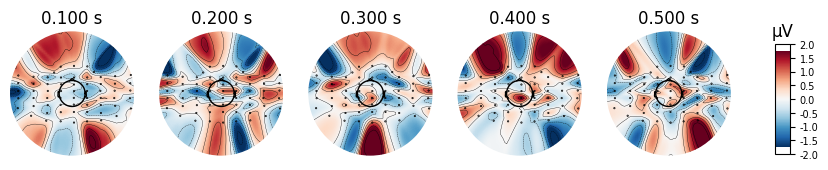

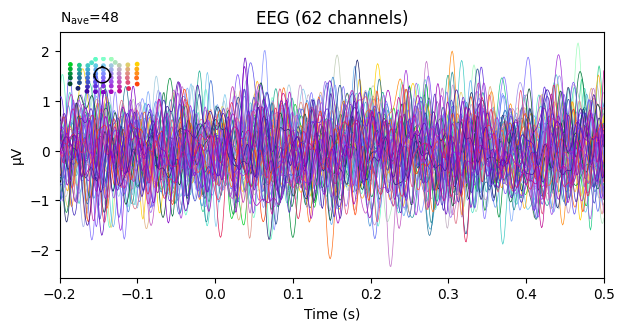

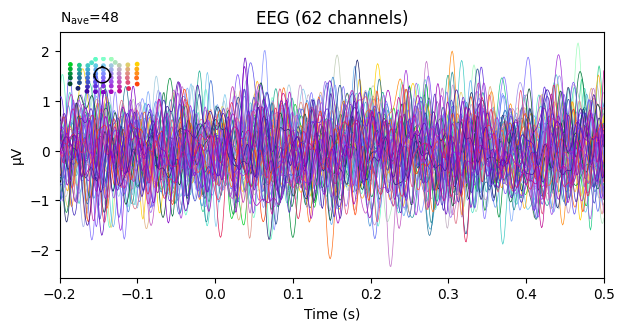

In [113]:
# Crear un objeto Raw con los datos y la información de los canales
eeg_generated_reshape=original_range_generated_eeg.reshape(62,50000)

eeg_generated_reshape=eeg_generated_reshape/1000

raw = mne.io.RawArray(eeg_generated_reshape, info)

# Aplicar un montaje estándar (posiciones de los electrodos) para visualizar correctamente los datos
raw.set_montage(montage)

# Filtrar los datos
raw.filter(l_freq=1, h_freq=52)

# Crear un objeto Epochs a partir de los datos en bruto
events = mne.make_fixed_length_events(raw, start=0, stop=raw.times[-1], duration=1)
epochs = mne.Epochs(raw, events)

# Calcular y visualizar el mapa cerebral
evoked = epochs.average()
evoked.plot_topomap(times=[0.1, 0.2, 0.3, 0.4, 0.5], ch_type='eeg', ncols=5)
evoked.plot(time_unit='s')

###  Visualitation Original Signal

In [103]:
eeg_data_original = mne.io.read_raw_fif(file_path, preload=True) #ultimo de la lista


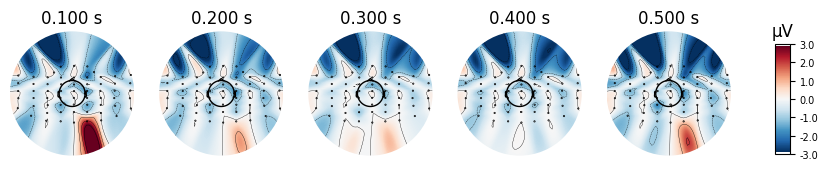

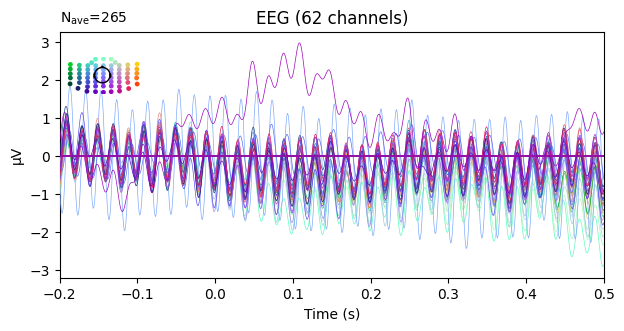

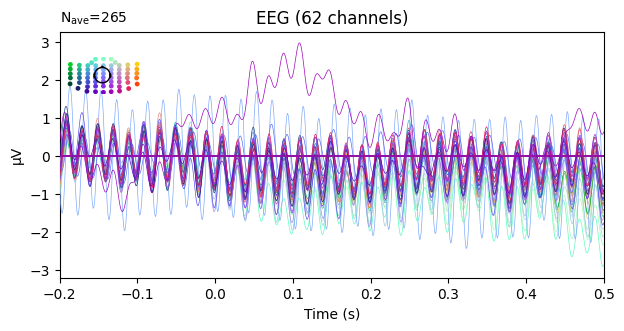

In [104]:
# Filtrar los datos
eeg_data_original.filter(l_freq=1, h_freq=52)

# Crear un objeto Epochs a partir de los datos en bruto
events = mne.make_fixed_length_events(eeg_data_original, start=0, stop=eeg_data_original.times[-1], duration=1)
epochs = mne.Epochs(eeg_data_original, events)

# Calcular y visualizar el mapa cerebral
evoked = epochs.average()
evoked.plot_topomap(times=[0.1, 0.2, 0.3, 0.4, 0.5], ch_type='eeg', ncols=5)
evoked.plot(time_unit='s')

In [118]:
from mne import read_source_estimate


print(__doc__)

# Paths to example data
sample_dir_raw = eeg_data_original
sample_dir = sample_dir_raw / 'MEG' / 'sample'
subjects_dir = sample_dir_raw / 'subjects'

fname_stc = sample_dir / 'sample_audvis-meg'

Automatically created module for IPython interactive environment


TypeError: unsupported operand type(s) for /: 'Raw' and 'str'

In [ ]:
sample